In [16]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
img = cv2.imread(r'test_images\sharapova1.jpg')
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

In [ ]:
gray

In [ ]:
plt.imshow(gray,cmap='gray')

In [17]:
face_cascade = cv2.CascadeClassifier('opencv\haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv\haarcascades\haarcascade_eye.xml')

In [ ]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.imshow(img[:,:,::-1])
plt.imshow(roi_color[:,:,::-1])

In [18]:
def get_cropped_img_if_2_eyes(img_pth):
    img = cv2.imread(img_pth)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color
        else:
            return None

In [ ]:
org_img = cv2.imread(r'test_images/sharapova2.jpg')
plt.imshow(org_img)

In [ ]:
cropped_img = get_cropped_img_if_2_eyes(r'test_images/sharapova1.jpg')
# plt.imshow(cropped_img)
# print(cropped_img)
cropped_img

In [19]:
pathToData = r'dataset'
pathToCroppedData = r'dataset\cropped'

In [20]:
import os
img_dirs = []
for entry in os.scandir(pathToData):
    if entry.is_dir(): img_dirs.append(entry.path)
img_dirs

['dataset\\lionel_messi',
 'dataset\\maria_sharapova',
 'dataset\\roger_federer',
 'dataset\\serena_williams',
 'dataset\\virat_kohli']

In [21]:
import shutil
if os.path.exists(pathToCroppedData):
    shutil.rmtree(pathToCroppedData)
os.mkdir(pathToCroppedData)

In [22]:
cropped_img_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 0
    celebrity_name = img_dir.split('\\')[-1]
    print(celebrity_name)

    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_img_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = os.path.join(pathToCroppedData,celebrity_name)#pathToCroppedData + '\\' + celebrity_name
            if not os.path.exists(cropped_folder):
                cropped_img_dirs.append(cropped_folder)
                os.makedirs(cropped_folder)
            
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = os.path.join(cropped_folder,cropped_file_name)#cropped_folder + "\\" + cropped_file_name

            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

lionel_messi
maria_sharapova
roger_federer
serena_williams
virat_kohli


In [23]:
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)
    return imArray_H

In [24]:

class_dict = dict()
for idx, celebrity_name in enumerate(celebrity_file_names_dict.keys(),-1):
    if celebrity_name != 'cropped':
        class_dict[celebrity_name]=idx
class_dict

{'lionel_messi': -1,
 'maria_sharapova': 0,
 'roger_federer': 1,
 'serena_williams': 2,
 'virat_kohli': 3}

In [25]:
X=[]
Y=[]
for celebrity_name, training_file in celebrity_file_names_dict.items():
    for training_image in training_file:
        img = cv2.imread(training_image)
        if img is not None:
            scaled_raw_img = cv2.resize(img,(32,32))
            img_har = w2d(img,'db1',5)
            scaled_img_har = cv2.resize(img_har,(32,32))
            combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
            X.append(combined_img)
            Y.append(class_dict[celebrity_name])
# len(X)
# len(X[0])
X = np.array(X).reshape(len(X),len(X[0])).astype(float)
X.shape

(157, 4096)

In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0)
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))])
pipe.fit(X_train,Y_train)
pipe.score(X_test,Y_test)

0.875

In [28]:
len(X_test)
print(classification_report(Y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

          -1       1.00      0.86      0.92         7
           0       0.90      0.82      0.86        11
           1       0.83      1.00      0.91         5
           2       0.80      0.80      0.80        10
           3       0.88      1.00      0.93         7

    accuracy                           0.88        40
   macro avg       0.88      0.90      0.88        40
weighted avg       0.88      0.88      0.87        40



In [29]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [30]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [31]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.820290,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.675000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.820652,{'logisticregression__C': 1}


In [32]:
best_estimators['svm'].score(X_test,Y_test)

0.875

In [33]:
best_estimators['random_forest'].score(X_test,Y_test)

0.625

In [34]:
best_estimators['logistic_regression'].score(X_test,Y_test)

0.95

In [35]:
best_clf = best_estimators['logistic_regression']

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,best_clf.predict(X_test))
cm

array([[ 7,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0],
       [ 0,  0,  4,  1,  0],
       [ 0,  0,  1,  9,  0],
       [ 0,  0,  0,  0,  7]], dtype=int64)

Text(69.0, 0.5, 'Truth')

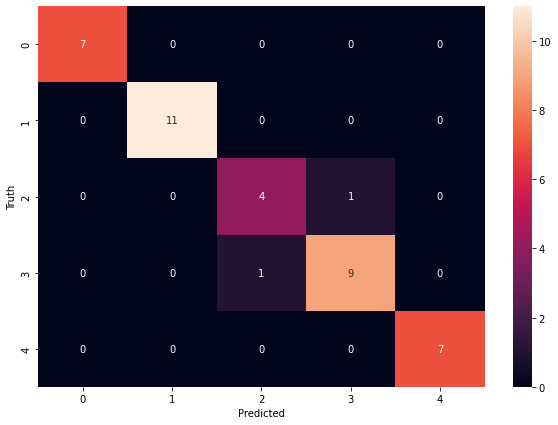

In [37]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
class_dict

{'lionel_messi': -1,
 'maria_sharapova': 0,
 'roger_federer': 1,
 'serena_williams': 2,
 'virat_kohli': 3}

In [39]:
!pip install joblib
import joblib
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))